## Py-DDA example notebook

This notebooks shows how you can get multiple Doppler winds from different radars. All that is needed are Cf-Compliant grids that share the same grid specifications. Tools such as Python ARM Radar Toolkit (Py-ART) (https://github.com/ARM-DOE/pyart) and LROSE (https://www.eol.ucar.edu/content/lidar-radar-open-software-environment) can create these grids for you. 

The PyDDA package is built on top of Py-ART. Therefore, Py-ART is needed for PyDDA to run. 

In [157]:
import pyart
import pydda
%pylab inline
import warnings
from distributed import Client, LocalCluster
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


First, we load our Cf-Compliant grids using Py-ART's read_grid function.

In [136]:
berr_grid = pyart.io.read_grid("/home/rjackson/data/berrwinds.20060120.004000.nc")
cpol_grid = pyart.io.read_grid("/home/rjackson/data/cpolwinds.20060120.004000.nc")
print(cpol_grid.fields.keys())

dict_keys(['reflectivity', 'region_dealias_velocity', 'ROI', 'corrected_velocity', 'AZ', 'EL', 'u', 'v', 'w', 'divergence', 'shear', 'shear_dir', 'vorticity'])


In [137]:
cpol_grid.x["data"]

masked_array(data=[-60000., -59000., -58000., -57000., -56000., -55000.,
                   -54000., -53000., -52000., -51000., -50000., -49000.,
                   -48000., -47000., -46000., -45000., -44000., -43000.,
                   -42000., -41000., -40000., -39000., -38000., -37000.,
                   -36000., -35000., -34000., -33000., -32000., -31000.,
                   -30000., -29000., -28000., -27000., -26000., -25000.,
                   -24000., -23000., -22000., -21000., -20000., -19000.,
                   -18000., -17000., -16000., -15000., -14000., -13000.,
                   -12000., -11000., -10000.,  -9000.,  -8000.,  -7000.,
                    -6000.,  -5000.,  -4000.,  -3000.,  -2000.,  -1000.,
                        0.,   1000.,   2000.,   3000.,   4000.,   5000.,
                     6000.,   7000.,   8000.,   9000.,  10000.,  11000.,
                    12000.,  13000.,  14000.,  15000.,  16000.,  17000.,
                    18000.,  19000.,  20000.,  2100

Next, we must specify the initial conditions. PyDDA currently has two options for the intial state:

    * pydda.retrieval.make_wind_field_from_profile - Make the intialization wind field be that from a sounding    
    * pydda.retrieval.make_constant_wind_field - Specify a constant wind field 
    
More options will be added in the future! In this example, we will load data from a sounding and use that as our intial state with no vertical motion. 
    

In [138]:
sounding = pyart.io.read_arm_sonde(
    "/home/rjackson/data/soundings/twpsondewnpnC3.b1.20060119.231600.custom.cdf")
print(sounding)
u_init, v_init, w_init = pydda.initialization.make_wind_field_from_profile(
        cpol_grid, sounding[1], vel_field='corrected_velocity')

(datetime.datetime(2006, 1, 19, 23, 16), <pyart.core.wind_profile.HorizontalWindProfile object at 0x7f7b6189d9e8>)


Next, we will retrieve the wind field! The output of these is a list of Py-ART Grids which correspond to the inputs with the wind fields added in. 

In [139]:
cpol_grid = pydda.constraints.make_constraint_from_era_interim(cpol_grid, file_name='era_file.nc')

Download ERA Interim data...
2019-03-15 11:10:37 ECMWF API python library 1.5.0
2019-03-15 11:10:37 ECMWF API at https://api.ecmwf.int/v1
2019-03-15 11:10:38 Welcome Robert Jackson
2019-03-15 11:10:38 In case of problems, please check https://confluence.ecmwf.int/display/WEBAPI/Web-API+Troubleshooting or contact servicedesk@ecmwf.int
2019-03-15 11:10:38 In case of delays, please check  service activity page https://apps.ecmwf.int/webapi-activity/
2019-03-15 11:10:39 Request submitted
2019-03-15 11:10:39 Request id: 5c8bce7fbbd91cdeee966a2b
2019-03-15 11:10:39 Request is submitted
2019-03-15 11:10:41 Request is queued
Calling 'nice mars /tmp/1e/4c/tmp-_marsamagcI.req'
mars - WARN -
mars - WARN - From 29 January 2019 10AM (UTC) MARS uses the interpolation
mars - WARN - provided by the MIR library. For more details, see
mars - WARN - https://confluence.ecmwf.int/display/UDOC/MARS+interpolation+with+MIR
mars - WARN -
PPDIR is /var/tmp/ppdir/x86_64
mars - INFO   - 20190315.161230 - Welcome 

In [158]:
cluster = LocalCluster(n_workers=2, processes=True)
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:42461 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 8 Memory: 67.48 GB


In [140]:
cpol_grid.fields.keys()

dict_keys(['reflectivity', 'region_dealias_velocity', 'ROI', 'corrected_velocity', 'AZ', 'EL', 'u', 'v', 'w', 'divergence', 'shear', 'shear_dir', 'vorticity', 'U_erainterim', 'V_erainterim', 'W_erainterim'])

In [170]:
Grids = pydda.retrieval.get_dd_wind_field_nested([cpol_grid, berr_grid], u_init, 
                                                 v_init, w_init, client=client, Co=0.1, Cm=1500.0, 
                                                 Cz=0, vel_name='corrected_velocity', 
                                                 refl_field='reflectivity',
                                                 frz=5000.0, filt_iterations=2, 
                                                 mask_outside_opt=False, upper_bc=1)

Calculating weights for radars 0 and 1
Calculating weights for models...
Starting solver 
rmsVR = 43.79107213440473
Total points:12629.0
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel | Max w  
|   0.8264|   0.4786|   0.0000|   0.0000|   0.0000|   0.0000|  20.8334
Norm of gradient: 0.0009638479899289387
Iterations before filter: 10
| Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel | Max w  
|   0.8264|   0.4786|   0.0000|   0.0000|   0.0000|   0.0000|  20.8334
Norm of gradient: 0.0009638479899289387
Iterations before filter: 20
Applying low pass filter to wind field...
Iterations after filter: 1
Iterations after filter: 2
Done! Time = 1.5
Waiting for nested grid to be retrieved...


Let's save our grid so we don't have to regenerate it again!

In [171]:
pyart.io.write_grid('example_grid_radar0.nc', Grids[0])
pyart.io.write_grid('example_grid_radar1.nc', Grids[1])

In [172]:
Grids = [pyart.io.read_grid('example_grid_radar1.nc'), pyart.io.read_grid('example_grid_radar0.nc')]
Grids_s = [pyart.io.read_grid('example_grid_radar0_singledop_nested.nc')]
#Grids = [cpol_grid, berr_grid]

In [28]:
from copy import deepcopy

def subtract_pyart_grids(Grid1, Grid2):
    dest_grid = deepcopy(Grid1)
    for key in Grid1.fields.keys():
        dest_grid.fields[key]["data"] -= Grid2.fields[key]["data"]
    return dest_grid

diff_grid = subtract_pyart_grids(Grids[0], Grids_s[0])

Finally, we will visualize the wind field. This is easy with the visualization module of PyDDA! PyDDA currently has support to plot wind barb plots through xy, xz, and yz cross sections. More types of plots (streamline plots, plots on geospatial grids) are planned as future features.

Text(0.5, 1.0, 'U wind difference @ 3 km')

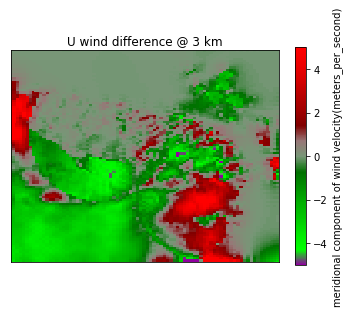

In [43]:
display = pyart.graph.GridMapDisplay(diff_grid)
display.plot_grid('u', level=3, vmin=-5, vmax=5, cmap='pyart_NWSVel')
plt.title('U wind difference @ 3 km')

Text(0.5, 1.0, 'V wind difference @ 3 km')

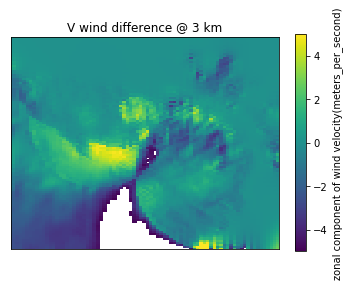

In [39]:
display = pyart.graph.GridMapDisplay(diff_grid)
display.plot_grid('v', level=3, vmin=-5, vmax=5)
plt.title('V wind difference @ 3 km')

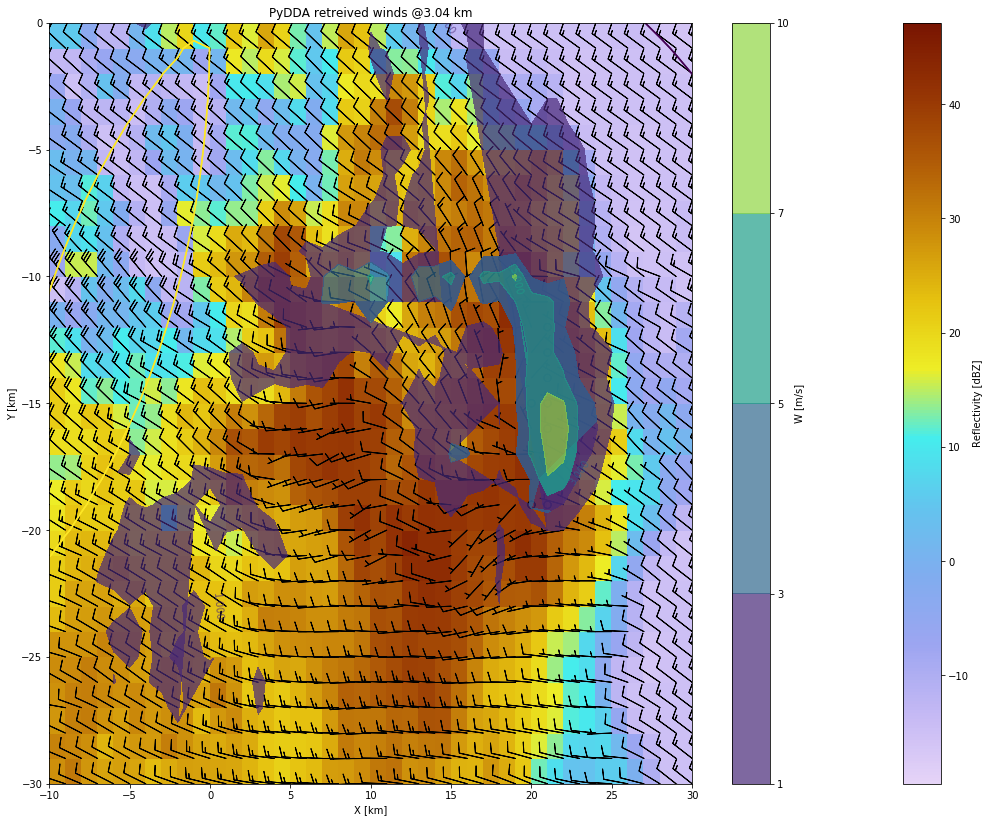

In [173]:
plt.figure(figsize=(18,14))
wind_speed = np.sqrt(Grids[0].fields["u"]["data"]**2+ Grids[0].fields["v"]["data"]**2)
w = Grids[0].fields["w"]["data"]
Grids[0].fields["reflectivity"]["long_name"] = "Reflectivity"
ax = pydda.vis.plot_horiz_xsection_barbs(Grids, None, 'reflectivity', level=3,                                           
                                                   colorbar_contour_flag=True,
                                                   barb_spacing_x_km=1.0,
                                                   barb_spacing_y_km=1.0,
                                                   w_vel_contours=[1,3,5,7,10])
ax.set_xlim([-10, 30])
ax.set_ylim([-30, 0])
wspddiff = np.sqrt(diff_grid.fields["u"]["data"]**2 + diff_grid.fields["v"]["data"]**2)
#wspddiff = np.ma.masked_where(wspddiff == 0, wspddiff)
#ax.contour(Grids[0].point_x["data"][3]/1e3, Grids[0].point_y["data"][3]/1e3, wspddiff[3],  
#                levels=np.linspace(1,5,3), colors='k', linestyle='-')
#c = ax.contourf(Grids[0].point_x["data"][3]/1e3, Grids[0].point_y["data"][3]/1e3, wspddiff[3],  
#                levels=np.linspace(1,5,3), colors='none', hatches=['/', '//'])
#plt.colorbar(c, ax=ax, label="Wind speed difference [m/s]")

KeyError: 'long_name'

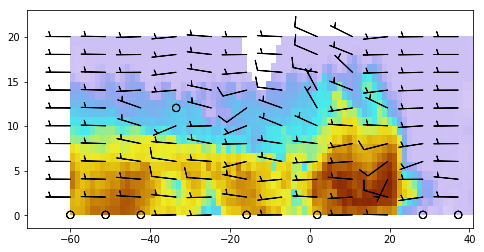

In [11]:
plt.figure(figsize=(8,4))
pydda.vis.plot_xz_xsection_barbs(Grids, None, 'reflectivity', level=40,
                                 barb_spacing_x_km=10.0,
                                 barb_spacing_z_km=2.0,
                                 wind_vel_contours=[5, 10, 20],
                                                  colorbar_contour_flag=True)

In [10]:
plt.figure(figsize=(8,4))
pydda.vis.plot_yz_xsection_barbs(Grids, None,'reflectivity', level=40,
                                 w_vel_contours=[1, 3, 5, 7],
                                 barb_spacing_y_km=10.0,
                                 barb_spacing_z_km=2.0,
                                 wind_vel_contours=[5, 10],
                                                  colorbar_contour_flag=True)

TypeError: plot_yz_xsection_streamlines() got an unexpected keyword argument 'barb_spacing_y_km'

<Figure size 576x288 with 0 Axes>

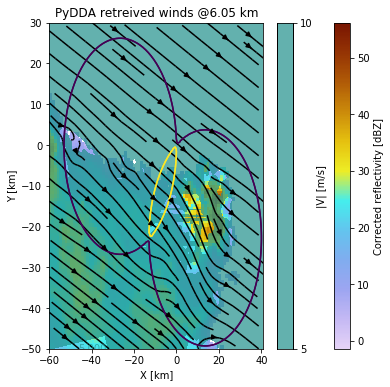

In [8]:
plt.figure(figsize=(6,6))
pydda.vis.plot_horiz_xsection_streamlines(Grids, None, 'reflectivity', level=6,
                                          wind_vel_contours=[5, 10],
                                                  colorbar_contour_flag=True)

(0, 15)

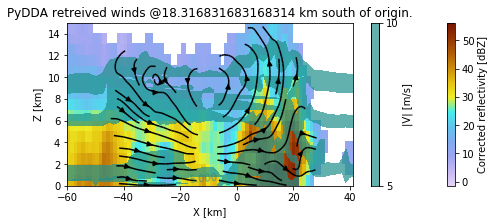

In [10]:
plt.figure(figsize=(8,3))
pydda.vis.plot_xz_xsection_streamlines(Grids, None, 'reflectivity', level=40,
                                 wind_vel_contours=[5, 10],
                                                  colorbar_contour_flag=True)
plt.ylim([0,15])

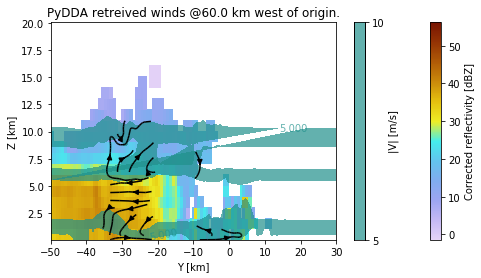

In [11]:
plt.figure(figsize=(8,4))
pydda.vis.plot_yz_xsection_streamlines(Grids, None,'reflectivity', level=40,
                                 wind_vel_contours=[5, 10],
                                                  colorbar_contour_flag=True)

## Doing a retrieval on a cluster

In [ ]:
from distributed import Client, LocalCluster

Start a dask distributed cluster. If you are running a retrieval on more than one machine, we 
highly recommend the use of dask-jobqueue for setting up your cluster. 

Dask-jobqueue is available here:
https://jobqueue.dask.org/en/latest/

In [ ]:
# Can also use something like dask-jobqueue to set up your cluster - this is for one machine 
cluster = LocalCluster(n_workers=2, processes=True)
client = Client(cluster)

In [ ]:
client

get_dd_wind_field_nested takes in the same parameters as get_dd_wind_field, except for a distributed client after w_init as a required entry.

In [ ]:
Grids = pydda.retrieval.get_dd_wind_field_nested([berr_grid, cpol_grid], u_init,
                                                 v_init, w_init, client, Co=100.0, Cm=1500.0, 
                                                 Cz=0, vel_name='VT', refl_field='DT',
                                                 frz=5000.0, filt_iterations=0, 
                                                 mask_outside_opt=True, upper_bc=1)

In [ ]:
pyart.io.write_grid('example_grid_radar0.nc', Grids[0])
pyart.io.write_grid('example_grid_radar1.nc', Grids[1])

In [ ]:
Grids = [pyart.io.read_grid('example_grid_radar0.nc'), pyart.io.read_grid('example_grid_radar1.nc')]

In [ ]:
plt.figure(figsize=(6,6))
pydda.vis.plot_horiz_xsection_barbs(Grids, None, 'DT', level=6,
                                    w_vel_contours=[3, 6, 9],
                                    barb_spacing_x_km=5.0,
                                    barb_spacing_y_km=15.0)

In [ ]:
plt.figure(figsize=(6,6))
pydda.vis.plot_horiz_xsection_streamlines(Grids, None, 'DT', level=6,
                                          w_vel_contours=[3, 6, 9],
                                          )